In [44]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve

# Paso 1: Generar datos sintéticos ampliados
n_datos=10
# Generar puntos factoriales ampliados
puntos_factoriales_ampliados = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]] * (n_datos // 4))  # Repetir para aumentar la cantidad de puntos

# Generar puntos centrales ampliados
puntos_centrales_ampliados = np.array([[0, 0] for _ in range(n_datos // 2)])  # Aumentar la cantidad de puntos centrales

# Combinar los puntos factoriales y centrales
disenho_exp_ampliado = np.concatenate((puntos_factoriales_ampliados, puntos_centrales_ampliados))

array([[-1, -1],
       [-1,  1],
       [ 1, -1],
       [ 1,  1],
       [-1, -1],
       [-1,  1],
       [ 1, -1],
       [ 1,  1],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0]])

In [43]:
# Necesitamos definir la función 'truemodel' 

def truemodel(x1, x2):
    # Esta es una función ejemplo para generar la calidad del lomito, puede ser ajustada según sea necesario
    return 5 + x1 - x2 + 0.5 * x1 * x2 + 0.8 * x1**2 + 0.8 * x2**2

# Ahora aplicaremos esta función al diseño experimental ampliado para generar los valores de Y
Y_ampliado = truemodel(disenho_exp_ampliado[:, 0], disenho_exp_ampliado[:, 1]) + np.random.normal(0, 0.5, len(disenho_exp_ampliado))

# Crear un DataFrame con los datos ampliados
datos_ampliados = pd.DataFrame(data=disenho_exp_ampliado, columns=['X1', 'X2'])
datos_ampliados['Y'] = Y_ampliado

datos_ampliados.head(10)  # Mostrar las primeras filas del conjunto de datos ampliado nuevamente

,X1,X2,Y
0,-1,-1,6.509684
1,-1,1,4.085909
2,1,-1,8.314166
3,1,1,7.133259
4,-1,-1,7.251236
5,-1,1,3.782839
6,1,-1,7.918629
7,1,1,6.763770
8,0,0,4.820223
9,0,0,4.593427


In [27]:
# Paso 2: Regresión polinomial de 2do orden
model = smf.ols('Y ~ X1 + X2 + I(X1**2) + I(X2**2) + I(X1*X2)', data=datos_ampliados).fit()

# Paso 3: ANOVA (curvatura significativa)
anova = sm.stats.anova_lm(model, typ=2)
anova  # Mostrar los resultados del ANOVA

,sum_sq,df,F,PR(>F)
X1,11.502604,1.0,100.545004,0.000008
X2,3.519573,1.0,30.764817,0.000543
I(X1 ** 2),8.444655,1.0,73.815278,0.000026
I(X2 ** 2),8.444655,1.0,73.815278,0.000026
I(X1 * X2),6.113821,1.0,53.441307,0.000083
Residual,0.915220,8.0,NaN,NaN


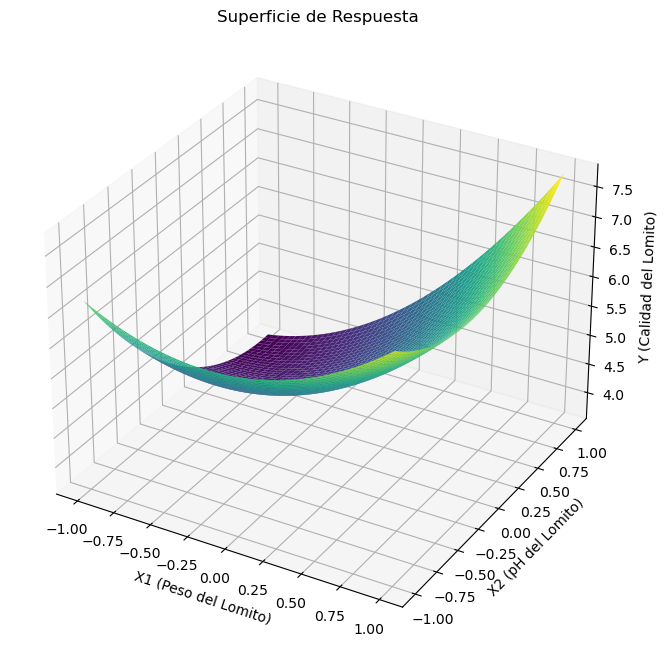

In [28]:
## Paso 4: Superficie de respuesta

# Crear una malla de valores para X1 y X2
x1_val = np.linspace(-1, 1, 50)
x2_val = np.linspace(-1, 1, 50)
x1_mesh, x2_mesh = np.meshgrid(x1_val, x2_val)

# Calcular los valores predichos de Y en la malla
y_mesh = model.predict(exog=dict(X1=x1_mesh.ravel(), X2=x2_mesh.ravel(), I_X1_2=x1_mesh.ravel()**2, I_X2_2=x2_mesh.ravel()**2, I_X1_X2=x1_mesh.ravel()*x2_mesh.ravel())).values.reshape(x1_mesh.shape)

# Crear la figura para la superficie de respuesta
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar la superficie
surf = ax.plot_surface(x1_mesh, x2_mesh, y_mesh, cmap='viridis', edgecolor='none')

# Etiquetas y título
ax.set_xlabel('X1 (Peso del Lomito)')
ax.set_ylabel('X2 (pH del Lomito)')
ax.set_zlabel('Y (Calidad del Lomito)')
ax.set_title('Superficie de Respuesta')

# Mostrar el gráfico
plt.show()

In [35]:
# Paso 5: Calcular los puntos estacionarios para el modelo de regresión del proyecto 1

# Imprimir los parámetros del modelo para referencia
print(model.params)

# Definir las ecuaciones para calcular los puntos estacionarios
def ecuaciones(p):
    x1, x2 = p
    ec1 = model.params['X1'] + 2 * model.params['I(X1 ** 2)'] * x1 + model.params['I(X1 * X2)'] * x2
    ec2 = model.params['X2'] + 2 * model.params['I(X2 ** 2)'] * x2 + model.params['I(X1 * X2)'] * x1
    return (ec1, ec2)

# Calcular el punto estacionario utilizando fsolve
punto_estacionario = fsolve(ecuaciones, (0, 0))
punto_estacionario

Intercept     4.715399
X1            1.199094
X2           -0.663285
I(X1 ** 2)    0.828329
I(X2 ** 2)    0.828329
I(X1 * X2)    0.874201
dtype: float64


array([-1.29594018,  1.08422984])

In [38]:
# Evaluación del punto estacionario para el Proyecto 1

# Calcular la respuesta óptima Y en el punto estacionario calculado anteriormente
optresp_proyecto1 = model.predict(exog=dict(X1=punto_estacionario[0], X2=punto_estacionario[1]))

# Mostrar los resultados para el Proyecto 1
punto_estacionario_proyecto1 = (punto_estacionario[0], punto_estacionario[1])
respuesta_optima_y_proyecto1 = optresp_proyecto1.values[0]

print("Punto Estacionario (X1, X2):",punto_estacionario_proyecto1)
print("Respuesta Óptima de Y:", respuesta_optima_y_proyecto1)

Punto Estacionario (X1, X2): (-1.2959401785100173, 1.084229842748695)
Respuesta Óptima de Y: 3.578845927694756


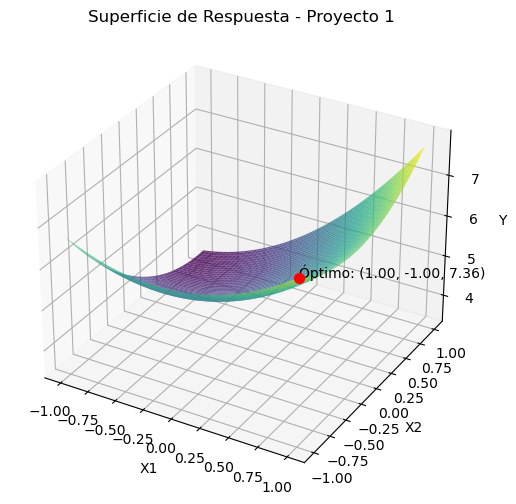

(array([ 1., -1.]), 7.360233612331267)

In [40]:

# Definición de la función true_model ajustada a los resultados del Proyecto 1
def true_model_proyecto1(x1, x2):
    # Usaremos los coeficientes del modelo de regresión obtenido en el Proyecto 1
    return (model.params['Intercept'] +
            model.params['X1'] * x1 +
            model.params['X2'] * x2 +
            model.params['I(X1 ** 2)'] * x1**2 +
            model.params['I(X2 ** 2)'] * x2**2 +
            model.params['I(X1 * X2)'] * x1 * x2)

# Crear una malla de valores para X1 y X2 para el Proyecto 1
x_proyecto1 = np.linspace(-1, 1, 100)
X1_proyecto1, X2_proyecto1 = np.meshgrid(x_proyecto1, x_proyecto1)
Y_proyecto1 = true_model_proyecto1(X1_proyecto1, X2_proyecto1)

# Graficar la superficie de respuesta para el Proyecto 1
fig_proyecto1 = plt.figure(figsize=(8, 6))
ax_proyecto1 = fig_proyecto1.add_subplot(111, projection='3d')
ax_proyecto1.plot_surface(X1_proyecto1, X2_proyecto1, Y_proyecto1, cmap='viridis', alpha=0.8)
ax_proyecto1.set_xlabel('X1')
ax_proyecto1.set_ylabel('X2')
ax_proyecto1.set_zlabel('Y')
ax_proyecto1.set_title('Superficie de Respuesta - Proyecto 1')

# Función objetivo para el Proyecto 1
def objective_function_proyecto1(params):
    x1, x2 = params
    return -true_model_proyecto1(x1, x2)

# Realizar la optimización para el Proyecto 1
result_proyecto1 = minimize(objective_function_proyecto1, initial_guess, bounds=((-1, 1), (-1, 1)))

# Punto óptimo y respuesta óptima para el Proyecto 1
optimal_point_proyecto1 = result_proyecto1.x
optimal_response_proyecto1 = -result_proyecto1.fun

# Mostrar el punto óptimo en la gráfica del Proyecto 1
ax_proyecto1.scatter(optimal_point_proyecto1[0], optimal_point_proyecto1[1], optimal_response_proyecto1, color='red', s=50)
ax_proyecto1.text(optimal_point_proyecto1[0], optimal_point_proyecto1[1], optimal_response_proyecto1, f'Óptimo: ({optimal_point_proyecto1[0]:.2f}, {optimal_point_proyecto1[1]:.2f}, {optimal_response_proyecto1:.2f})', color='black')

plt.show()

# Resultados de la optimización para el Proyecto 1
optimal_point_proyecto1, optimal_response_proyecto1
